In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date

random_seed = 42

In [2]:
date_parser = lambda x : datetime.strptime(x, "%d/%m/%Y %H:%M:%S")
df = pd.read_csv("../data/Modelar_Intermedio_UH2021.txt", sep="|", parse_dates=['fecha'],
                 date_parser=date_parser)

## 2. Preprocesamiento de Datos

### Atributos no necesarios

Se eliminan las columnas de los atributos categóricos nominales `estado` y `dia_atipico` al haber sido transformados a atributos "dummy".

In [3]:
df2 = df.drop(["dia_atipico", "estado"], axis=1)

### Duplicados

**¿Puede haber varias entradas de un mismo id en un mismo día?**

In [4]:
df_grouped = df2.groupby(['fecha', 'id'])

In [5]:
df_grouped.size()

fecha       id    
2015-06-01  21972     1
            23910     1
            24306     2
            27144     1
            27504     1
                     ..
2016-09-30  456982    1
            457416    1
            457422    1
            458650    1
            458660    2
Length: 2029816, dtype: int64

Por ejemplo `id` = 24306 para `fecha` = 2015-06-01

In [6]:
df2.loc[(df2.fecha=="2015-06-01") & (df2.id==24306)]

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,antiguedad,unidades_vendidas,weekday,month,rotura,no_rotura,transito,dia_tipico,dia_alta_demanda,dia_baja_demanda
2,2015-06-01,24306,13,A,46.0,NaN,0,NaN,0,0,6,0,1,0,1,0,0
3,2015-06-01,24306,13,A,46.0,NaN,0,NaN,0,0,6,0,1,0,1,0,0


In [7]:
sum(list(df_grouped.size() > 1))

677904

In [8]:
len(df[df2.duplicated()])

2004985

Hay filas repetidas en el dataset. En concreto **677904 casos**, haciendo un total de **2004985 filas**.

Se procede a eliminar los casos duplicados.

In [9]:
df_duplicates_removed = df2.drop_duplicates(keep="first")
print("Número de filas tras eliminar duplicados: ", len(df_duplicates_removed))

Número de filas tras eliminar duplicados:  2040037


### Missing values

Comprobamos qué categorías tienen valores `null`.

In [10]:
df_duplicates_removed.isnull().any()

fecha                False
id                   False
visitas              False
categoria_uno        False
categoria_dos         True
precio                True
campaña              False
antiguedad            True
unidades_vendidas    False
weekday              False
month                False
rotura               False
no_rotura            False
transito             False
dia_tipico           False
dia_alta_demanda     False
dia_baja_demanda     False
dtype: bool

In [11]:
print("Porcentaje (%) de valores null: ")
100 * df_duplicates_removed.isnull().sum() / len(df_duplicates_removed)

Porcentaje (%) de valores null: 


fecha                 0.000000
id                    0.000000
visitas               0.000000
categoria_uno         0.000000
categoria_dos         0.215339
precio               68.620618
campaña               0.000000
antiguedad           23.568935
unidades_vendidas     0.000000
weekday               0.000000
month                 0.000000
rotura                0.000000
no_rotura             0.000000
transito              0.000000
dia_tipico            0.000000
dia_alta_demanda      0.000000
dia_baja_demanda      0.000000
dtype: float64

Los atributos `categoria_dos`, `precio` y `antiguedad` tienen *missing values*. En la información del dataset nos dicen que para `precio` hay que completarlo con el valor de la fecha anterior más cercana. De los demás no dice nada. 

In [12]:
df_updated_prices = df_duplicates_removed.copy()

In [13]:
df_updated_prices['precio'] = df_duplicates_removed.groupby(['id'])['precio'].ffill()

In [14]:
df_updated_prices.head()

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,antiguedad,unidades_vendidas,weekday,month,rotura,no_rotura,transito,dia_tipico,dia_alta_demanda,dia_baja_demanda
0,2015-06-01,21972,0,C,75.0,NaN,0,5241.0,0,0,6,0,1,0,1,0,0
1,2015-06-01,23910,5,C,170.0,6.07,0,5241.0,3,0,6,0,1,0,1,0,0
2,2015-06-01,24306,13,A,46.0,NaN,0,NaN,0,0,6,0,1,0,1,0,0
4,2015-06-01,27144,15,E,230.0,NaN,0,4064.0,0,0,6,0,1,0,1,0,0
5,2015-06-01,27504,7,C,157.0,NaN,0,5261.0,0,0,6,0,1,0,1,0,0


In [15]:
df_updated_prices['precio'].isnull().sum()

260447

In [16]:
len(df_updated_prices[(df_updated_prices['id'] == 21972) & (df_updated_prices['precio'].isnull())])

5

In [17]:
df_updated_prices[(df_updated_prices['id'] == 21972)][:7]

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,antiguedad,unidades_vendidas,weekday,month,rotura,no_rotura,transito,dia_tipico,dia_alta_demanda,dia_baja_demanda
0,2015-06-01,21972,0,C,75.0,NaN,0,5241.0,0,0,6,0,1,0,1,0,0
8306,2015-06-02,21972,0,C,75.0,NaN,0,5241.0,0,1,6,0,1,0,1,0,0
16612,2015-06-03,21972,1,C,75.0,NaN,0,5241.0,0,2,6,0,1,0,1,0,0
24918,2015-06-04,21972,1,C,75.0,NaN,0,5241.0,0,3,6,0,1,0,1,0,0
33224,2015-06-05,21972,3,C,75.0,NaN,0,5241.0,0,4,6,0,1,0,1,0,0
41530,2015-06-06,21972,1,C,75.0,5.84,0,5241.0,3,5,6,0,1,0,1,0,0
49836,2015-06-07,21972,1,C,75.0,5.84,0,5241.0,0,6,6,0,1,0,1,0,0


In [18]:
len(df_updated_prices[(df_updated_prices['id'] == 21972) & (df_updated_prices['precio'].notnull())])

482

In [19]:
len(df_updated_prices[(df_updated_prices['id'] == 21972)])

487

Hay algunos valores con el precio nulo que no tienen valor anterior no-nulo más próximo como se muestra arriba.

Para estos valores se rellenará con el precio más antiguo del que se tenga constancia.

In [20]:
df_fill_prices = df_updated_prices.copy()
df_fill_prices['precio'] = df_updated_prices.sort_values(by="fecha", ascending=False) \
                                .groupby(['id'])['precio'].ffill()

<hr>

La columna `antiguedad` puede descartarse ya que:
* No hay forma de calcular los valores para los ejemplo que son null. 
* Para los ejemplos no null, el valor de `antiguedad` es fijo para el mismo producto independientemente de la fecha.

In [21]:
df_drop_antiguedad = df_fill_prices.drop(["antiguedad"], axis=1)

In [22]:
df_drop_antiguedad.head()

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,unidades_vendidas,weekday,month,rotura,no_rotura,transito,dia_tipico,dia_alta_demanda,dia_baja_demanda
0,2015-06-01,21972,0,C,75.0,5.84,0,0,0,6,0,1,0,1,0,0
1,2015-06-01,23910,5,C,170.0,6.07,0,3,0,6,0,1,0,1,0,0
2,2015-06-01,24306,13,A,46.0,7.85,0,0,0,6,0,1,0,1,0,0
4,2015-06-01,27144,15,E,230.0,6.12,0,0,0,6,0,1,0,1,0,0
5,2015-06-01,27504,7,C,157.0,10.74,0,0,0,6,0,1,0,1,0,0


<hr>

Para la columna `categoria_dos` hay pocos casos en los que el valor es null. Se comprobará si existe la opción de completar el campo con las filas con el mismo `id` que tengan un valor.

In [23]:
def check_categoria_dos(row):
    aux_array = df_drop_antiguedad[(df_drop_antiguedad.id == row.id) & \
                              (df_drop_antiguedad["categoria_dos"]).notnull()].categoria_dos
    if len(aux_array) > 0:
        print(new_value, row.categoria_dos)
        

In [24]:
index_no_cat2 = df_drop_antiguedad["categoria_dos"].isnull()

df_drop_antiguedad[index_no_cat2].apply(check_categoria_dos, axis=1);

No existen productos que tengan un valor en `categoria_dos` para una fecha y ninguna para otra. Para todos los casos en los que `categoria_dos` es null, lo es para todas las filas con el mismo `id`.

Se utilizará `IterativeImputer` para poder rellenar `categoria_dos` utilizando el resto de los atributos. Se hará tras la codificación de los atributos categóricos en el siguiente apartado.

Los atributos categóricos ordinales (`categoria_uno`) serán transformados a atributos numéricos para poder utilizar `IterativeImputer`.

In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
cat1_encoded = encoder.fit_transform(df_drop_antiguedad['categoria_uno'].to_numpy().reshape(-1,1).ravel())

In [26]:
df_encoded = df_drop_antiguedad.copy()

df_encoded['categoria_uno'] = cat1_encoded

Ahora es posible rellenar el valor de `categoria_dos` utilizando `IterativeImputer`.

In [27]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

In [28]:
imputer = IterativeImputer(random_state=0)

index_cat2 = df_encoded["categoria_dos"].notnull()

# Solo nos interesa rellenar "categoria_dos", "precio" no. "fecha" no es utilizado por IterativeImputer
imputer.fit(df_encoded[index_cat2].drop(["fecha", "precio", "id"], axis=1).values) 

IterativeImputer(random_state=0)

In [29]:
cat2_filled = imputer.transform(df_encoded[index_no_cat2].drop(["fecha", "precio", "id"], axis=1).values)

In [30]:
df_prep = df_encoded.copy()

index_aux = list(df_encoded.drop(["fecha", "precio"], axis=1).columns).index("categoria_dos")
df_prep.loc[index_no_cat2,["categoria_dos"]] = cat2_filled[:, index_aux]

### Scaler

Se estandarizan los atributos numéricos (excepto `id`).

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
cat_att = ['categoria_uno', 'categoria_dos', 'month', 'weekday', 'rotura', 'no_rotura', 'transito',
           'dia_tipico', 'dia_alta_demanda', 'dia_baja_demanda', 'campaña']

scaler = StandardScaler()

df_scaled = df_prep.copy()
df_scaled.loc[:, ["visitas",
                  "precio"]] = scaler.fit_transform(df_prep.drop(cat_att + ["fecha","unidades_vendidas","id"],axis=1))

In [33]:
df_scaled.head()

,fecha,id,visitas,categoria_uno,categoria_dos,precio,campaña,unidades_vendidas,weekday,month,rotura,no_rotura,transito,dia_tipico,dia_alta_demanda,dia_baja_demanda
0,2015-06-01,21972,-0.209219,2,75.0,-1.103112,0,0,0,6,0,1,0,1,0,0
1,2015-06-01,23910,-0.200812,2,170.0,-1.094568,0,3,0,6,0,1,0,1,0,0
2,2015-06-01,24306,-0.187361,0,46.0,-1.028447,0,0,0,6,0,1,0,1,0,0
4,2015-06-01,27144,-0.183999,4,230.0,-1.092711,0,0,0,6,0,1,0,1,0,0
5,2015-06-01,27504,-0.197450,2,157.0,-0.921092,0,0,0,6,0,1,0,1,0,0


## 3. Creación de Modelo(s)

### División de conjuntos. 

* Entrenamiento: 70%
* Testeo: 20%
* Validación: 10%

Se debe descartar como atributos `unidades_vendidas`, al ser lo que se pretende predecir, `fecha` al no ser un atributo sobre el que se pueda entrenar a un modelo e `id` al no ser un atributo relacionado directamente con cada caso.

In [34]:
from sklearn.model_selection import train_test_split

X = df_scaled.drop(["unidades_vendidas", "fecha", "id"], axis=1).values
y = df_scaled["unidades_vendidas"].values

In [35]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,test_size=.2,random_state =random_seed)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/8, random_state =random_seed)

### Función de pérdida:

Podrá ser utilizada como función de pérdida a mejorar en modelos de redes neuronales y servirá para calcular qué error tiene cada modelo.

In [37]:
from sklearn.metrics import mean_squared_error

def rRMSE_np (y_real, y_pred):
    rmse = mean_squared_error(y_real, y_pred, squared=False) # Root Mean Squared Error
    return rmse / np.mean(y_pred) # rRMSE
    
def CF_np (y_real, y_pred):
    # Cuando la demanda no haya superado a la predicción
    return sum([i <= j for i, j in zip(y_real, y_pred)])/len(y_real) 

def contest_loss_np (y_real, y_pred): # y_real e y_pred son objetos numpy
    cf =  CF_np(y_real, y_pred)
    rrmse = rRMSE_np(y_real, y_pred)
    return 0.7 * rrmse + 0.3 * (1 - cf)

Se crean las mismas funciones para ser utilizadas por las librerías `tensorflow` y `keras`.

In [38]:
import keras.backend as K

''' Funciones auxiliares '''
def rRMSE(y_real, y_pred):
    rmse = K.sqrt(K.mean(K.square(y_pred - y_real))) # Root Mean Squared Error
    
    return rmse / K.mean(y_pred) # rRMSE
    
def CF(y_real, y_pred):
    aux = K.cast(y_real <= y_pred, K.floatx())
    
    cf = K.mean(aux) # Cuando la demanda no haya superado a la predicción
    
    return cf

''' Función de pérdida del concurso '''
def contest_loss (y_real, y_pred): # y_real e y_pred son tensores de Keras
    
    rrmse = rRMSE(y_real, y_pred)
    
    cf = CF(y_real, y_pred)
    
    return 0.7 * rrmse + 0.3 * (1 - cf)


''' Función de pérdida customizada '''
def custom_loss (y_real, y_pred): # y_real e y_pred son tensores de Keras
    
    rrmse = rRMSE(y_real, y_pred)
    
    cf = CF(y_real, y_pred)
    
    return 0.7 * rrmse + 0.3 * (1 - cf)

### Random Forest Regressor

Importancia relativa de los atributos calculada viendo cuantos nodos de los árboles usan ese atributo para reducir la impureza

In [39]:
from sklearn.ensemble import RandomForestRegressor


random_forest_regressor = RandomForestRegressor(n_estimators=10)
random_forest_regressor.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10)

In [40]:
for name, score in zip(df_scaled.drop(["unidades_vendidas", "fecha", "id"], axis=1).columns,
                       random_forest_regressor.feature_importances_):
    print(name, score)

visitas 0.41007874170121483
categoria_uno 0.01613901326710192
categoria_dos 0.06709461213564652
precio 0.2609920823683293
campaña 0.0021111696564067397
weekday 0.05939588489129881
month 0.1605807701317946
rotura 0.0023508825703590286
no_rotura 0.002822424833343565
transito 0.002433850512366266
dia_tipico 0.005120244146244418
dia_alta_demanda 0.00541752131190604
dia_baja_demanda 0.00546280247398768


<hr>

In [41]:
from sklearn.model_selection import cross_val_predict 

cv=5

pred_train_val_rf = cross_val_predict(random_forest_regressor, X_train_val, y_train_val, cv=cv, n_jobs=-1)

In [43]:
contest_loss_np(y_train_val, pred_train_val_rf)

2.341932958640254

### XGBoost

In [44]:
import xgboost as xg 

xgb_r = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 10, seed = random_seed) 

pred_train_val_xgb = cross_val_predict(xgb_r, X_train_val, y_train_val, cv=cv, n_jobs=-1)

In [45]:
contest_loss_np(y_train_val, pred_train_val_xgb)

2.6651251463142427

### Redes Neuronales

In [46]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf

In [47]:
nn = Sequential()
nn.add(Dense(50, input_dim=len(X_train_val[0]), kernel_initializer='normal', activation='relu'))
nn.add(Dense(30, activation='relu'))
nn.add(Dense(10, activation='relu'))
nn.add(Dense(5, activation='relu'))
nn.add(Dense(1, activation='linear'))
print(nn.summary())

dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(nn, to_file=dot_img_file, show_shapes=True)

es = EarlyStopping(monitor = 'loss', mode = 'min', min_delta=0.01, verbose = 1, patience=2, restore_best_weights=True);

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                700       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 2,601
Trainable params: 2,601
Non-trainable params: 0
_________________________________________________________________
None


In [48]:
nn.compile(loss=custom_loss,
           optimizer=Adam(learning_rate=0.001),
           metrics=[contest_loss, rRMSE, CF])

In [49]:
nn.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 15, callbacks = [es])

Epoch 1/10
95202/95202 [==============================] - 65s 685us/step - loss: 0.6821 - contest_loss: 0.6821 - rRMSE: 0.9699 - CF: 0.9893 - val_loss: 0.6756 - val_contest_loss: 0.6756 - val_rRMSE: 0.9601 - val_CF: 0.9884
Epoch 2/10
95202/95202 [==============================] - 65s 684us/step - loss: 0.6759 - contest_loss: 0.6759 - rRMSE: 0.9608 - CF: 0.9887 - val_loss: 0.6743 - val_contest_loss: 0.6743 - val_rRMSE: 0.9603 - val_CF: 0.9930
Epoch 3/10
95202/95202 [==============================] - 65s 679us/step - loss: 0.6740 - contest_loss: 0.6740 - rRMSE: 0.9579 - CF: 0.9881 - val_loss: 0.6739 - val_contest_loss: 0.6739 - val_rRMSE: 0.9589 - val_CF: 0.9911
Epoch 00003: early stopping


Se calcula la pérdida del modelo sobre el conjunto de testeo.

In [50]:
pred_test_nn = nn.predict(X_test)

In [51]:
print("CF: ", CF_np(y_test, pred_test_nn))
print("rRMSE: ", rRMSE_np(y_test, pred_test_nn))

CF:  [0.98819631]
rRMSE:  0.9896602858513049


In [52]:
contest_loss_np(y_test, pred_test_nn)

array([0.69630331])

Se realiza una impresión de los diez primeros valores de test y se ve como el modelo abusa de la métrica CF para siempre tener una cantidad suficiente para hacer frente a la demanda. Se representa gráficamente para tener una idea más clara sobre cómo actúa el modelo.

In [53]:
for i,j in zip(y_test[:10], pred_test_nn[:10]):
    print(i,j)

0 [32.38694]
0 [30.796656]
0 [36.74499]
0 [31.14204]
0 [37.061245]
9 [44.1233]
3 [37.913055]
3 [36.161797]
0 [32.925785]
0 [31.54438]


In [54]:
def plot_preds(y_test, y_pred): 
    y_test_idx_sort = np.argsort(y_test)[::-1]

    plt.figure(figsize=(20, 7))
    plt.plot(range(len(y_test)), y_test[y_test_idx_sort], label="Real Values", alpha=0.8, color="blue")
    plt.plot(range(len(y_test)), y_pred[y_test_idx_sort], label="Predicted Values", alpha=0.8, color="red")
    plt.ylabel("Unidades Vendidas")
    plt.xlabel("Productos")
    plt.legend()
    plt.show()

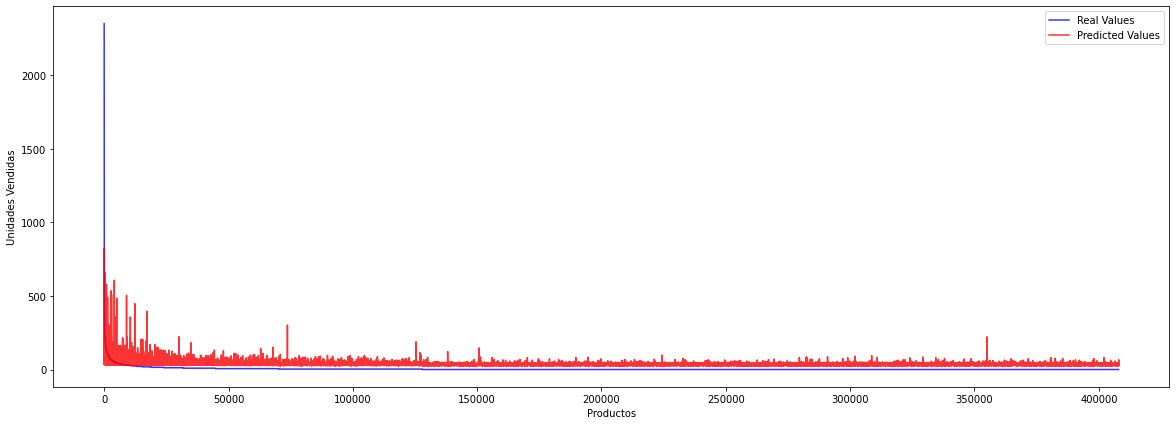

In [55]:
plot_preds(y_test, pred_test_nn)

Utilizando una función de pérdida sustituyendo la métrica rRMSE por RMSE se obtiene una gráfica que parece ser más precisa al verdadero volumen de unidades vendidas por producto por día. Pero utilizando esta pérdida, como se puede esperar, se obtiene una peor evaluación con la función objetivo al tener una mayor rRMSE. Por ello, se decide utilizar la primera de estas funciones.

Como se indica en las instrucciones: *[...] Está será la métrica a minimizar: **(0.7 * rRMSE) + (0.3 * (1 - CF))**, siendo los mejores trabajos los que consigan los valores más reducidos de dicha métrica. [...]*

![../img/index.png](../img/index.png)

## 4. Predicción de datos no conocidos.

Se realiza el entrenamiento sobre todo nuestro conjunto de datos y se predice sobre los datos que encontramos en `Estimar2.txt`.

In [56]:
nn.fit(X, y, epochs = 10, batch_size = 15, callbacks = [es])

Epoch 1/10
136003/136003 [==============================] - 88s 646us/step - loss: 0.6746 - contest_loss: 0.6746 - rRMSE: 0.9588 - CF: 0.9882
Epoch 2/10
136003/136003 [==============================] - 86s 629us/step - loss: 0.6721 - contest_loss: 0.6721 - rRMSE: 0.9548 - CF: 0.9872
Epoch 3/10
136003/136003 [==============================] - 87s 638us/step - loss: 0.6711 - contest_loss: 0.6711 - rRMSE: 0.9531 - CF: 0.9868
Epoch 00003: early stopping


In [57]:
date_parser = lambda x : datetime.strptime(x, "%Y-%m-%d")
X_predict = pd.read_csv("../data/Estimar2.txt", sep="|", parse_dates=['fecha'],
                     date_parser=date_parser)

/home/jaime/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [58]:
X_predict.head()

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad
0,2016-10-01,21972,5,C,75,No Rotura,"5,84",0,0,5150
1,2016-10-02,21972,15,C,75,No Rotura,"5,84",0,0,5150
2,2016-10-03,21972,5,C,75,No Rotura,"5,84",0,0,5150
3,2016-10-04,21972,5,C,75,No Rotura,"5,84",0,0,5150
4,2016-10-05,21972,0,C,75,No Rotura,"5,84",0,0,5150


In [59]:
X_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212841 entries, 0 to 212840
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   fecha          212841 non-null  datetime64[ns]
 1   id             212841 non-null  int64         
 2   visitas        212841 non-null  int64         
 3   categoria_uno  212841 non-null  object        
 4   categoria_dos  212841 non-null  object        
 5   estado         212841 non-null  object        
 6   precio         212841 non-null  object        
 7   dia_atipico    212841 non-null  int64         
 8   campaña        212841 non-null  int64         
 9   antiguedad     212841 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 16.2+ MB


<hr>

Se realiza todo el proceso de preprocesamiento de datos sobre los datos de testeo:

In [60]:
# Sustitución de valores para los que categoria_dos es igual a '-' 
X_predict[X_predict.categoria_dos == '-'] = None
X_predict["categoria_dos"] = X_predict["categoria_dos"].astype(np.float64) 

X_predict["weekday"] = X_predict["fecha"].map(lambda x: x.weekday()) # Lunes = 0; Domingo = 6
X_predict["month"] = X_predict["fecha"].map(lambda x: x.month)

X_predict['estado'] = X_predict['estado'].astype('category')
X_predict['categoria_uno'] = X_predict['categoria_uno'].astype('category')

X_predict["rotura"] = X_predict["estado"].map(lambda x: 1 if x=='Rotura' else 0).astype('category')
X_predict["no_rotura"] = X_predict["estado"].map(lambda x: 1 if x=='No Rotura' else 0).astype('category')
X_predict["transito"] = X_predict["estado"].map(lambda x: 1 if x=='Transito' else 0).astype('category')

X_predict["dia_tipico"] = X_predict["dia_atipico"].map(lambda x: 1 if x==0 else 0)
X_predict["dia_alta_demanda"] = X_predict["dia_atipico"].map(lambda x: 1 if x==1 else 0)
X_predict["dia_baja_demanda"] = X_predict["dia_atipico"].map(lambda x: 1 if x==1 else 0)

X_predict = X_predict.drop(["dia_atipico", "estado"], axis=1)

In [61]:
# X_predict = X_predict.drop_duplicates(keep="first")

X_predict["precio"] = X_predict["precio"].str.replace(",", ".").astype(float)

X_predict['precio'] = X_predict.groupby(['id'])['precio'].ffill()

X_predict['precio'] = X_predict.sort_values(by="fecha", ascending=False) \
                                .groupby(['id'])['precio'].ffill()

X_predict = X_predict.drop(["antiguedad"], axis=1)

In [62]:
# Caso nan para categoria_uno con caso más común
cat1_null = X_predict["categoria_uno"].isnull()

X_predict["categoria_uno"][cat1_null] = 'A'

In [63]:
X_predict["categoria_uno"] = X_predict["categoria_uno"].apply(lambda x: np.mode(X_predict["categoria_uno"]) if x is None else x)

encoder = LabelEncoder()

cat1_encoded = encoder.fit_transform(X_predict['categoria_uno'].to_numpy().reshape(-1,1).ravel())

X_predict['categoria_uno'] = cat1_encoded

In [64]:
imputer = IterativeImputer(random_state=0)

index_cat2 = X_predict["categoria_dos"].notnull()
index_no_cat2 = X_predict["categoria_dos"].isnull()

# Solo nos interesa rellenar "categoria_dos", "precio" no. Además, "fecha" e "id" no son utilizados por IterativeImputer
imputer.fit(X_predict[index_cat2].drop(["fecha", "precio", "id"], axis=1).values) 

cat2_filled = imputer.transform(X_predict[index_no_cat2].drop(["fecha", "precio", "id"], axis=1).values)

index_aux = list(X_predict.drop(["fecha", "precio"], axis=1).columns).index("categoria_dos")
X_predict.loc[index_no_cat2,["categoria_dos"]] = cat2_filled[:, index_aux]

In [65]:
cat_att = ['categoria_uno', 'categoria_dos', 'month', 'weekday', 'rotura', 'no_rotura', 'transito',
           'dia_tipico', 'dia_alta_demanda', 'dia_baja_demanda', 'campaña']

scaler = StandardScaler()

X_predict.loc[:, ["visitas",
                  "precio"]] = scaler.fit_transform(X_predict.drop(cat_att + ["fecha","id"],axis=1))

In [66]:
X_predict_prepared = X_predict.drop(["fecha", "id"], axis=1).values

<hr>

Se realizan las predicciones y se insertan en el fichero correspondiente.

In [67]:
pred_nn = nn.predict(X_predict_prepared)

In [68]:
y_predict = X_predict[["fecha","id"]].copy()
y_predict["unidades_vendidas"] = pred_nn

In [69]:
y_predict.to_csv("../data/Rento_UH2021.txt", sep="|", index=False)

<hr>